This script document the framework used in the paper "Multimodal Critique of Authority – Humor as a Function of Dissent during the COVID-19 Pandemic" (paper in progress). 

The framework in question can be summarized as following:

### Step 1: Contrastive image-text loss for representation learning
### Step 2: Hybrid-modal attention for cross-modal fusion
### Step 3: Humor classification
### Step 4: Mutual learning

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import easyocr
from transformers import CLIPModel, CLIPProcessor
import transformers
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from info_nce import InfoNCE, info_nce

In [30]:
# Load M-CLIP model, this will be used for the texts embeddings
model_name = "M-CLIP/XLM-Roberta-Large-Vit-B-32"
clip_text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
clip_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, otherwise fallback to CPU
print(device)

cuda


In [42]:
# initalize the ocr
reader = easyocr.Reader(["no", "en"])
PIL.Image.ANTIALIAS = PIL.Image.LANCZOS

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\easyocr\detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load

# Step 1: Definitions

In [36]:
def get_text_features(text):
    """Extracts text features using M-CLIP/XLM-Roberta-Large-Vit-B-32, handling long texts."""
    try:
        max_tokens = 512  # 
        # Tokenize the input text
        tokens = clip_tokenizer(text, return_tensors="pt", padding=False, truncation=False).input_ids[0]
        # Ensures no empty chunk is created
        token_chunks = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens)]
    
        # Check if any chunk is empty (which could happen with very short texts or edge cases)
        if any(len(chunk) == 0 for chunk in token_chunks):
            print("⚠️ Warning: Found empty token chunks!")
            return None  # Early exit if there are empty chunks
        # Decode chunks back into text
        text_chunks = [clip_tokenizer.decode(chunk, skip_special_tokens=True) for chunk in token_chunks]
        
        # Process each chunk and extract its features
        chunk_features = []
        for chunk in text_chunks:
            # Tokenize each chunk and get the model features
            inputs = clip_tokenizer(chunk, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                features = clip_text_model.forward([chunk], clip_tokenizer).squeeze().cpu().numpy()
            chunk_features.append(features)
        
        # Average the features from all chunks to get the final representation
        final_text_features = np.mean(chunk_features, axis=0) if chunk_features else np.zeros((512,))
        
        return final_text_features
    except Exception as e:
        print(f"⚠️ Error extracting text features: {e}")
        return None

In [37]:
def extract_text_easyocr(image_path):
    """Extracts text from an image using EasyOCR."""
    try:
        results = reader.readtext(image_path, detail=0)  # Extract text without coordinates
        return " ".join(results)  # Join extracted words into a single string
    except Exception as e:
        print(f"⚠️ OCR failed for {image_path}: {e}")
        return ""

In [38]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to extract image features
def get_image_features(image_path):
    """Extracts image embeddings from CLIP."""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy()

In [ ]:
# class MultimodalDataset(Dataset):
#     def __init__(self, dataframe, tokenizer, image_transform):
#         self.dataframe = dataframe
#         self.tokenizer = tokenizer
#         self.image_transform = image_transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         text = self.dataframe.iloc[idx]["combined_text"]
#         image_path = self.dataframe.iloc[idx]["image_path_image_filename_image_1"]
#         label = self.dataframe.iloc[idx]["label"]

#         # Extract text features using get_text_features
#         text_features = get_text_features(text)
        
#         # Extract image features using get_image_features
#         image_features = get_image_features(image_path)

#         return torch.tensor(text_features), torch.tensor(image_features), torch.tensor(label).float()

In [ ]:
# Prepare the dataset
df = pd.read_excel("D:/sample_images_full.xlsx")
df["label"] = df["label"].apply(lambda x: 1 if x > 0 else 0)
df["image_path_image_filename_image_1"] = df["image_path_image_filename_image_1"].str.replace(r"^D:/", "E:/", regex=True)

In [43]:
df["image_text"] = df["image_path_image_filename_image_1"].apply(extract_text_easyocr)
df["combined_text"] = df["tweet"] + " " + df["image_text"]

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [77]:
df["text_features"] = df["combined_text"].apply(get_text_features)
df["image_features"] = df["image_path_image_filename_image_1"].apply(get_image_features)

⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error extracting text features: index out of range in self
⚠️ Error

c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [84]:
df = df.dropna(subset=["text_features", "image_features"])

In [110]:
# Assuming df["text_features"] and df["image_features"] are numpy arrays
text_embeddings = torch.tensor(df["text_features"].tolist())
image_embeddings = torch.tensor(df["image_features"].tolist())

# text_embeddings = text_embeddings.unsqueeze(0)  # Shape becomes (1, batch_size, embedding_dim)
# image_embeddings = image_embeddings.unsqueeze(0)
image_embeddings = image_embeddings.squeeze(1)

In [111]:
print(text_embeddings.shape)

torch.Size([2158, 512])


In [112]:
print(image_embeddings.shape)

torch.Size([2158, 512])


In [113]:
print(df["label"].value_counts())

label
0    1773
1     385
Name: count, dtype: int64


In [114]:
# Define the temperature parameter for scaling the dot-product similarity
temperature = 0.07

def contrastive_loss(text_embeddings, image_embeddings, temperature=0.07):
    # Normalize the embeddings
    text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
    image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
    
    # Compute similarity matrix (dot product)
    similarity_matrix = torch.matmul(text_embeddings, image_embeddings.T) / temperature

    # Create labels for positive pairs (diagonal of the similarity matrix)
    labels = torch.arange(text_embeddings.size(0)).to(text_embeddings.device)
    
    # Cross-entropy loss based on similarity matrix
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss

In [ ]:
# class FusionModel(nn.Module):
#     def __init__(self, embedding_dim, num_heads=8):
#         super(FusionModel, self).__init__()
#         self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads)
#         self.linear = nn.Linear(embedding_dim, embedding_dim)  # Optional for dimension adjustment

#     def forward(self, text_embeddings, image_embeddings):
#         # Concatenate text and image embeddings along the batch dimension
#         embeddings = torch.cat([text_embeddings, image_embeddings], dim=0)  # (batch_size*2, embedding_dim)
        
#         # Reshape to match the format required by MultiheadAttention (sequence_length, batch_size, embedding_dim)
#         embeddings = embeddings.unsqueeze(0)  # (1, batch_size*2, embedding_dim)
        
#         # Apply multi-head attention
#         attn_output, attn_output_weights = self.attention(embeddings, embeddings, embeddings)
        
#         # Reshape the output to match the original embedding shape
#         fused_embeddings = attn_output.squeeze(0)  # (batch_size*2, embedding_dim)
        
#         # Optionally apply a final linear transformation
#         fused_embeddings = self.linear(fused_embeddings)
#         return fused_embeddings

In [ ]:
import torch
import torch.nn as nn

class FusionModel(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8):
        super(FusionModel, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Linear(embed_dim, embed_dim)  # Ensures final output is [batch, 512]
        self.norm = nn.LayerNorm(embed_dim)  # Normalization for stability

    def forward(self, text_embeddings, image_embeddings):
        # Ensure image_embeddings has the correct shape
        image_embeddings = image_embeddings.squeeze(1)  # Removes extra dimension if present
        
        # Concatenate along sequence dimension: [batch, 2, 512]
        combined = torch.stack([text_embeddings, image_embeddings], dim=1)

        # Apply multi-head attention
        attn_output, _ = self.multihead_attn(combined, combined, combined)  # Self-attention

        # Aggregate: Use mean pooling across the 2 modalities
        fused = attn_output.mean(dim=1)  # Shape: [batch, 512]

        # Pass through a final FC layer + normalization
        fused = self.fc(fused)
        fused = self.norm(fused)

        return fused

In [124]:
embedding_dim = text_embeddings.size(1)  # Assume text and image embeddings have the same dimension
fusion_model = FusionModel(embedding_dim)
fused_embeddings = fusion_model(text_embeddings, image_embeddings)


In [125]:
print(fused_embeddings.shape)

torch.Size([2158, 512])


In [126]:
print(fused_embeddings[:5])

tensor([[ 0.0204,  0.3916,  0.5710,  ..., -1.5662,  0.4650, -1.0300],
        [ 0.7083,  0.8559,  0.2113,  ..., -0.9875,  1.2207, -1.4478],
        [ 1.3664,  1.8215,  1.4045,  ..., -0.3203,  2.1708, -1.2498],
        [ 1.1744,  0.5577,  0.7000,  ..., -0.4145,  1.4421, -1.7461],
        [-0.2091,  1.0547,  0.4468,  ..., -1.8466,  0.3201, -1.0512]],
       grad_fn=<SliceBackward0>)


In [127]:
print(f"Min value: {fused_embeddings.min()}")
print(f"Max value: {fused_embeddings.max()}")

Min value: -4.789506435394287
Max value: 4.397152423858643


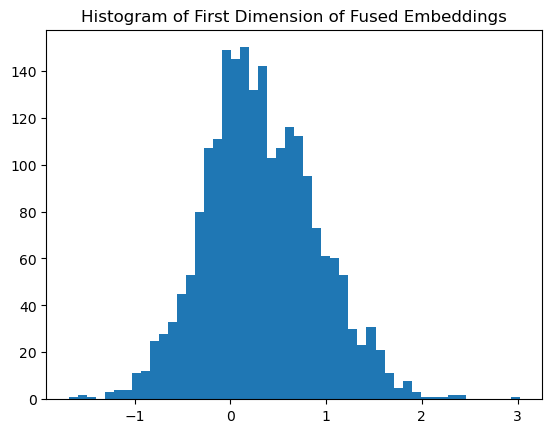

In [128]:
import matplotlib.pyplot as plt

plt.hist(fused_embeddings[:, 0].detach().numpy(), bins=50)
plt.title("Histogram of First Dimension of Fused Embeddings")
plt.show()

# Step 2: Training the model

In [146]:
X = fused_embeddings  # The fused embeddings
y = df['label'].values  # The labels for humor classification (0 or 1)

# Split the data into training and test sets (e.g., 80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors for model training
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

C:\Users\sirifris\AppData\Local\Temp\ipykernel_23464\1974732226.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\sirifris\AppData\Local\Temp\ipykernel_23464\1974732226.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


In [147]:
from imblearn.over_sampling import SMOTE

# Convert to NumPy arrays for SMOTE
X_train = np.array(X_train.tolist())  # Convert list of arrays to 2D NumPy array
y_train = np.array(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long)


# Print new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(1): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(1): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0): 1, tensor(0)

In [148]:

# Define a simple feed-forward neural network for binary classification
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, 1)  # Second fully connected layer
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary output

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation after the first layer
        x = self.fc2(x)  # Apply the second layer
        x = self.sigmoid(x)  # Apply sigmoid to get a probability (0-1)
        return x

# Instantiate the model
model = Classifier(input_dim=512)  # The input dimension matches the fused embedding size (512)

In [149]:
# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [150]:
# Set the model to training mode
model.train()

# Define the number of epochs
epochs = 10

# Train the model
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass: Compute predicted y by passing X to the model
    outputs = model(X_train_resampled)

    # Calculate the loss
    loss = criterion(outputs.squeeze(), y_train_resampled.float())

    # Backward pass: Compute gradient
    loss.backward()

    # Update the weights
    optimizer.step()

    # Print loss every 100 epochs
    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.6974
Epoch [2/10], Loss: 0.6406
Epoch [3/10], Loss: 0.6061
Epoch [4/10], Loss: 0.5728
Epoch [5/10], Loss: 0.5567
Epoch [6/10], Loss: 0.5371
Epoch [7/10], Loss: 0.5230
Epoch [8/10], Loss: 0.5113
Epoch [9/10], Loss: 0.4985
Epoch [10/10], Loss: 0.4920


In [151]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(X_test)  # Get model outputs
    predicted_labels = torch.argmax(predictions, dim=1)  # Convert logits to class labels

    # Compute accuracy
accuracy = accuracy_score(y_test, predicted_labels)

    # Compute precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted_labels, average="binary")

    # Print classification report
print("Classification Report:\n", classification_report(y_test, predicted_labels))

    # Print confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

    # Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       355
           1       0.00      0.00      0.00        77

    accuracy                           0.82       432
   macro avg       0.41      0.50      0.45       432
weighted avg       0.68      0.82      0.74       432

Confusion Matrix:
 [[355   0]
 [ 77   0]]
Accuracy: 0.8218
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sirifris\.conda\envs\poli_reco\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\